In [ ]:
#|default_exp comparison_space
## Standard libraries
import os
import math
import graphtools
import numpy as np
import time
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
# from IPython.display import set_matplotlib_formats
# matplotlib_inline.backend_inline.set_matplotlib_formats()
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import jax
import jax.numpy as jnp
jax.devices()

%load_ext autoreload
%autoreload 2

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Comparison Space Construction
> Making graphs flat

The construction of the comparison space is the most delicate operation diffusion curvature performs. The key to our construction is ensuring that diffusion, at a single scale, behaves equivalently on the manifold and the graph. Recall our connections to Ollivier's theory: we just need to ensure that the *jump* of diffusion is the same in both spaces. Curvature emerges from the interactions of diffusion at higher timesteps.

Our comparisons take pure graphs as input. We don't change the euclidean comparison space (which we sample uniformly from an nd random distribution). Instead, we tune the parameters of the kernel to minimize the KLD between the target jump and the average jump in our (boundary-excluded) comparison space. Thus, the beating heart of this approach is the differentiable graph constructor which is expressive enough to approximate a wide variety of graphs).

The most contentious point of this implementation is how to compute the $W_1$ distances. We need a metric for each of the graphs; but how is this to be constructed, given that the graph itself is in flux? We have the geodesic distances for the sampled euclidean points, but those won't be on the same scale as whatever graph distance we use on the manifold.

Our solution is to use PHATE distances with $t=1$. This requires only taking the log of the diffusion matrix, and for a single scale of distances is basically a way of converting affinities back into distances.

In [ ]:
#|export
from diffusion_curvature.graphs import generic_kernel, diffusion_matrix_from_affinities
from diffusion_curvature.distances import phate_distances_differentiable, pairwise_euclidean
from diffusion_curvature.utils import random_jnparray
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion, entropy_of_diffusion
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax

class EuclideanComparisonSpace(nn.Module):
    dimension:int  # dimension of comparison space
    num_points:int # num points to sample; best determined as a subset of the number of points in your manifold.
    jump_of_diffusion:jax.Array # the W1 distance from a single step of diffusion (t=1) to its origin
    fraction_of_points:float = 0.8
    comparison_type:str = "entropy"

    def setup(self):
        # compute optimal number of points given dimension
        self.Rn = jnp.concatenate([jnp.zeros((1,self.dimension)), 2*random_jnparray(self.num_points-1, self.dimension)-1])
        self.num_useful_points = int(self.fraction_of_points * self.num_points)
        # Sort values by distance to center point (i.e. the origin)
        distances_to_center = (self.Rn**2).sum(-1)
        sorting_idxs = jnp.argsort(distances_to_center)
        self.Rn = self.Rn[sorting_idxs]
        # precompute distances for kernel
        self.D = pairwise_euclidean(self.Rn,self.Rn)
        # initialize tunable parameters
        sigma_base = nn.initializers.constant(0.7)
        self.sigma = self.param(
            'kernel bandwidth',
            sigma_base, # Initial value of kernel bandwidth
            1 # size - it's just one value.
        )
        # anisotropy_base = nn.initializers.constant(0.5)
        self.anisotropic_density_normalization = 1
        # self.anisotropic_density_normalization = self.param(
        #     'anisotropic normalization',
        #     anisotropy_base, # Initial value of kernel bandwidth
        #     1 # size - it's just one value.
        # )


    def __call__(self):
        # normalize anisotropic density normalization to fit between 0 and 1
        # print(f"sigma = {self.sigma} alpha = {self.anisotropic_density_normalization}")
        A = generic_kernel(self.D, self.sigma, jax.nn.relu(self.anisotropic_density_normalization))
        P = diffusion_matrix_from_affinities(A)
        # print(f"AFTER ALL THAT - the diffusion matrix has max {jnp.max(P)}")
        if jnp.min(P) < 0: raise ValueError("P has negative values ", jnp.min(P))
        # D_manifold = phate_distances_differentiable(P)
        match self.comparison_type:
            case "wasserstein":
                W1 = wasserstein_spread_of_diffusion(self.D,P) # vector of all W1 values in comparison space.
                # discard edge values; take only top 80% of W1s, corresponding to closest 80% of values.
                # TODO: 80% is arbitrary and could be improved.
                spreads_near_center = W1[:-self.num_useful_points]
            case "entropy":
                # print(P)
                H = entropy_of_diffusion(P)
                spreads_near_center = H[:-self.num_useful_points]
        
        return {
            'mean jump difference':jnp.abs(jnp.mean(spreads_near_center) - self.jump_of_diffusion), 
            'A':A, 
            'P':P, 
            'D':self.D
        }

In [ ]:
# import jax.random as random
# model = EuclideanComparisonSpace(dimension=2, num_points=1000, jump_of_diffusion=0.47)
# key1, key2 = jax.random.split(jax.random.key(0))
# params = model.init(key2)

In [ ]:
#|export
import optax
import jax.random as random
def fit_comparison_space_model(model, max_epochs = 1000, verbose=False, lr = 1e-3):
    def train_comparison_space_model(params):
        out_dict = model.apply(params)
        return out_dict['mean jump difference']
    key1, key2 = jax.random.split(jax.random.key(0))
    params = model.init(key2)
    tx = optax.adam(learning_rate=lr)
    opt_state = tx.init(params)
    loss_grad_fn = jax.value_and_grad(train_comparison_space_model)
    for i in range(max_epochs):
        loss_val, grads = loss_grad_fn(params)
        if loss_val < 1e-5: break
        updates, opt_state = tx.update(grads,opt_state)
        params = optax.apply_updates(params,updates)
        if verbose:
            if i % 10 == 0: print(f"at {i}, loss is {loss_val}")
        if loss_val != loss_val: raise ValueError("NANS! Look out!")
    if verbose: print("ending with loss value", loss_val)
    return params

Here's an example of instantiating and fitting a comparison space.

In [ ]:
model = EuclideanComparisonSpace(dimension=2, num_points=1000, jump_of_diffusion=0.47, comparison_type="wasserstein")
params = fit_comparison_space_model(model, max_epochs=1000)
euclidean_stuffs = model.apply(params) # dictionary containing A, P, D

In [ ]:
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion

In [ ]:
P_euclidean = euclidean_stuffs['P']
D_euclidean = euclidean_stuffs['D']
wass_spreads = wasserstein_spread_of_diffusion(D_euclidean, P_euclidean)

In [ ]:
params

{'params': {'kernel bandwidth': Array([0.37664464], dtype=float32)}}

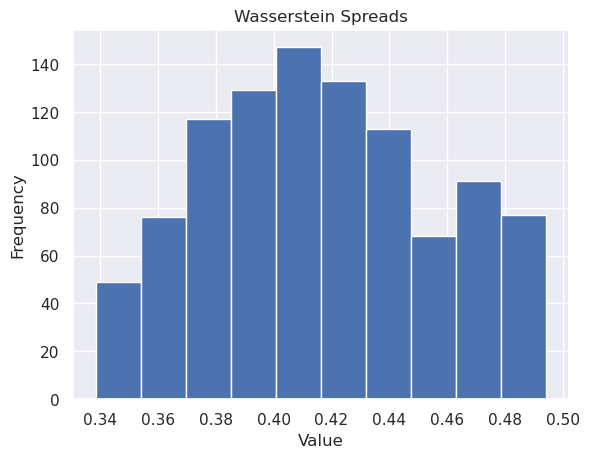

In [ ]:
# Plot histogram
plt.hist(wass_spreads, bins=10)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Wasserstein Spreads')
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
model = EuclideanComparisonSpace(dimension=2, num_points=1000, jump_of_diffusion=0.47, comparison_type="entropy",)
params = fit_comparison_space_model(model, max_epochs=1000, verbose=False, lr=0.01)
euclidean_stuffs = model.apply(params) # dictionary containing A, P, D

In [ ]:
from diffusion_curvature.diffusion_laziness import entropy_of_diffusion

In [ ]:
P_euclidean = euclidean_stuffs['P']
entropies = entropy_of_diffusion(P_euclidean)

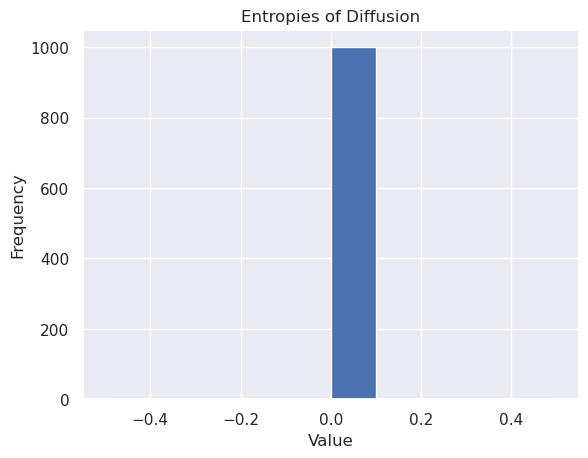

In [ ]:
plt.hist(entropies, bins=10)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Entropies of Diffusion')
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
params['params']

{'kernel bandwidth': Array([nan], dtype=float32)}

The fitting has worked, adjusting the kernel until our imaginary wasserstein spread value is achieved pretty uniformly.

# Pointcloud Construction

In [ ]:
#|export
import pygsp
import numpy as np
import graphtools

def get_graph_type(G):
    tt = str(type(G)).split('.')[-1][:3].lower()
    # TODO: Support for MNN graphs
    if tt == 'mnn': raise NotImplementedError("MNN Graphs require manual indices. These are not yet supported by our graph flattener.")
    if tt in ['knn']: return tt
    else: return 'exact'

def euclidean_comparison_graph(G:pygsp.graphs.Graph, dimension):
        """
        Constructs a flat graph, hewn from uniform random noise of the supplied dimension.
        Calculates the powered diffusion matrix on this graph.
        """
        noise = np.concatenate([np.zeros((1,dimension)), 2*np.random.rand(G.K.shape[0]-1,dimension)-1])
        # Build a graph out of the noise, with all of the same kernel settings as our first graph
        # NOTE: The graph building settings must be scale invariant! 
        params = G.get_params()
        needed_keys = ['data', 'n_pca', 'knn', 'decay', 'bandwidth', 'bandwidth_scale', 
                    'knn_max', 'anisotropy', 'beta', 'adaptive_k', 'n_landmark', 'n_landmark', 
                    'n_svd', 'n_jobs']
        found_keys = {} # TODO: Likely a more elegant way to do this
        for nk in needed_keys:
            if nk in params.keys():
                found_keys[nk] = params[nk]
            else:
                found_keys[nk] = None
        
        G_flat = graphtools.Graph(
            data = noise,
            n_pca = found_keys['n_pca'],
            knn = found_keys['knn'],
            decay = found_keys['decay'],
            bandwidth = found_keys['bandwidth'],
            bandwidth_scale = found_keys['bandwidth_scale'],
            knn_max = found_keys['knn_max'],
            anisotropy = found_keys['anisotropy'],
            beta = found_keys['beta'],
            adaptive_k = found_keys['adaptive_k'],
            n_landmark = found_keys['n_landmark'],
            n_svd = found_keys['n_svd'],
            n_jobs = found_keys['n_jobs'],
            graphtype = get_graph_type(G),
        )
        return G_flat.to_pygsp()

# Experiments

Now that we have automatic comparison space construction, we need to test it. Below, we run experiments to answer each of these questions:
1. Does matching the W1 (or Entropic) jump of diffusion actually produce the same kernel parameters?
2. Does this work even for graphs constructed from manifolds of non flat curvatures, like the plane and sphere?
3. Does it work against more complex kernels, like the alpha-decay kernel, or knn kernel? 

## 1. Does it produce the same kernel parameters?

Here are two heatmaps of the predicted versus actual kernel parameters in the easiest possible situation. We have two planes of the same dimension and same number of points, and use the same kernel. Can matching the jump of diffusion predict the correct parameters?

In [ ]:
from diffusion_curvature.datasets import plane, sphere, paraboloid

In [ ]:
#|hide
alphas = np.array([1])
sigmas = np.arange(0.1, 2.5, 0.25)
# loop through every combination of alpha and sigma and construct a graph using the generic_kernel function
alpha_store = np.zeros((len(alphas), len(sigmas)))
sigma_store = np.zeros((len(alphas), len(sigmas)))
X_plane = plane(1000)
D_plane = pairwise_euclidean(X_plane, X_plane)
jump_store_entropic = np.zeros((len(alphas), len(sigmas)))
jump_store_wasserstein = np.zeros((len(alphas), len(sigmas)))
for i, alpha in tqdm(enumerate(alphas)):
    for j, sigma in enumerate(sigmas):
        A = generic_kernel(D_plane, sigma, alpha)
        P = diffusion_matrix_from_affinities(A)
        e1 = entropy_of_diffusion(P)[0]
        w1 = wasserstein_spread_of_diffusion(D_plane, P)[0]
        jump_store_entropic[i][j] = e1
        jump_store_wasserstein[i][j] = w1
        # fit comparison graph
        model = EuclideanComparisonSpace(dimension=2, num_points=1000, jump_of_diffusion=e1, comparison_type="entropy",)
        params = fit_comparison_space_model(model, max_epochs=1000, verbose=False, lr=0.01)
        alpha_store[i][j] = 1 #float(jax.nn.relu(params['params']['anisotropic normalization']))
        sigma_store[i][j] = float(params['params']['kernel bandwidth'])

0it [00:00, ?it/s]

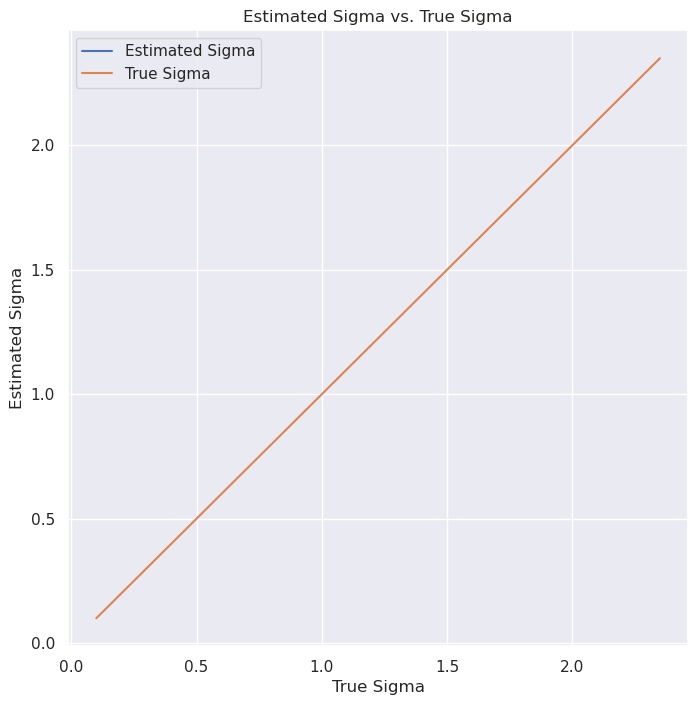

In [ ]:
# plot the sigma stored against the real sigmas
plt.figure(figsize=(8,8))
plt.plot(sigmas, sigma_store[0], label="Estimated Sigma")
plt.plot(sigmas, sigmas, label="True Sigma")
plt.xlabel("True Sigma")
plt.ylabel("Estimated Sigma")
plt.title("Estimated Sigma vs. True Sigma")
plt.legend()
plt.show()

How does the jump of diffusion change with these parameters?

# Grid Construction

In [ ]:
#|export
import numpy as np
def construct_ndgrid(*args):
    # Construct an ndgrid of points
    ndgrid = np.meshgrid(*args, indexing='ij')
    points = np.vstack(list(map(np.ravel, ndgrid))).T
    return points
def construct_ndgrid_from_shape(dim, points_per_dim):
    # Construct an ndgrid of points
    ranges = [np.arange(start=-1,stop=1,step=2/points_per_dim) for _ in range(dim)]
    points = construct_ndgrid(*ranges)
    # move the element closest to the origin to the front
    distances_to_origin = (points**2).sum(-1)
    sorting_idxs = np.argsort(distances_to_origin, )
    points = points[sorting_idxs]
    return points

In [ ]:
from diffusion_curvature.kernels import pygsp_graph_from_points
from diffusion_curvature.core import DiffusionCurvature

In [ ]:

DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1
)

n = 100
gx_curvatures = []
rx_curvatures = []


for i in range(n):
    # create n copies of gx and rx
    gx_copy = construct_ndgrid_from_shape(3,10)
    rx_copy = np.concatenate([np.zeros((1,3)), np.random.rand(1000,3)*2-1])
    
    # create graphs from the copies
    Gx_copy =  graphtools.Graph(gx_copy, knn=15, anisotropy=1, decay=None).to_pygsp()
    Rx_copy =  graphtools.Graph(rx_copy, knn=15, anisotropy=1, decay=None).to_pygsp()
    
    # calculate unsigned curvature of the copies
    gx_curvature = DC.unsigned_curvature(Gx_copy, t=15)[0]
    rx_curvature = DC.unsigned_curvature(Rx_copy, t=15)[0]
    
    # append the curvatures to the list
    gx_curvatures.append(gx_curvature)
    rx_curvatures.append(rx_curvature)

# calculate mean and standard deviation of the curvatures
gx_mean = np.mean(gx_curvatures)
gx_std = np.std(gx_curvatures)
rx_mean = np.mean(rx_curvatures)
rx_std = np.std(rx_curvatures)

# print the results
print(f"Mean unsigned curvature of gx: {gx_mean:.4f} +/- {gx_std:.4f}")
print(f"Mean unsigned curvature of rx: {rx_mean:.4f} +/- {rx_std:.4f}")


Mean unsigned curvature of gx: 6.7488 +/- 0.0000
Mean unsigned curvature of rx: 6.6859 +/- 0.0384


In [ ]:
gx

NameError: name 'gx' is not defined

# Diffusion Maps for Graph Comparison Spaces

In [ ]:
#|export
import jax.numpy as jnp
from diffusion_curvature.graphs import diff_aff

def diffusion_coordinates(G, t = 1, plot_evals = False):
    P_symmetric = jnp.array(diff_aff(G).toarray())
    W = jnp.array(G.W.toarray())
    D = jnp.sum(W, axis=1)
    # given symmetric diffusion matrix and density, constructs diffusion map
    Dnoh = jnp.diag(D**-0.5)
    # Decompose Ms
    eig_vals, eig_vecs = jnp.linalg.eigh(P_symmetric)
    # sort eigenvalues and eigenvectors(they are inconsistently sorted by default)
    sorted_idxs = jnp.argsort(eig_vals)
    eig_vals = eig_vals[sorted_idxs]
    eig_vecs = eig_vecs[:,sorted_idxs]
    # Normalize the eigenvector
    eig_psi_components = Dnoh @ eig_vecs
    eig_psi_components = eig_psi_components @ jnp.diag(jnp.power(jnp.linalg.norm(eig_psi_components, axis=0), -1))
    # Remove the trivial eigenvalue and eigenvector
    eig_vals = eig_vals[:-1]
    if plot_evals:
        print(eig_vals)
        fig, ax = plt.subplots()
        ax.bar([str(i) for i in range(len(eig_vals))], eig_vals**t)
        ax.set_title("Evals")
        plt.show()
    eig_psi_components = eig_psi_components[:,:-1]
    # Construct the diffusion map
    # diff_map = eig_psi_components @ np.diag(eig_vals**t)
    diff_map = eig_vals**t * eig_psi_components
    diff_map = diff_map[:,::-1]
    diff_map = diff_map
    return diff_map


In [ ]:
from diffusion_curvature.datasets import sphere
import graphtools

In [ ]:

X, ks = sphere(1000)
G = graphtools.Graph(X, knn=15, anisotropy=1, decay=None).to_pygsp()
W = jnp.array(G.W.toarray())

In [ ]:
dcoords = diffusion_coordinates(G)

<matplotlib.collections.PathCollection>

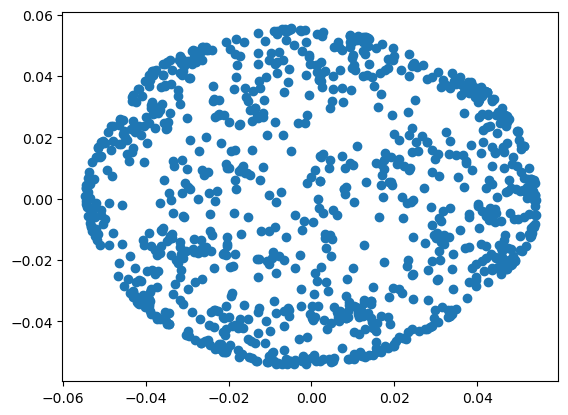

In [ ]:
plt.scatter(dcoords[:,0],dcoords[:,1])

# Mean Entropies of Flat Spaces

In [ ]:
#|export
import h5py
def load_average_entropies(filename):
    d = {}
    with h5py.File(filename,'r') as f:
        for dim in f.keys():
            d[int(dim)] = {}
            for knn in f[dim].keys():
                d[int(dim)][int(knn)] = {}
                for t in f[dim][knn].keys():
                    d[int(dim)][int(knn)][int(t)] = f[dim][knn][t][()]
    return d

In [ ]:
d = load_average_entropies('../data/entropies_averaged.h5')
d

{1: {10: {25: 4.1617084}, 15: {25: 4.5504103}, 5: {25: 3.4661007}},
 2: {10: {25: 5.775014}, 15: {25: 6.2073145}, 5: {25: 4.912664}},
 3: {10: {25: 7.301388}, 15: {25: 7.7671103}, 5: {25: 6.2948627}},
 4: {10: {25: 8.641593}, 15: {25: 8.925011}, 5: {25: 7.6750712}},
 5: {10: {25: 9.111419}, 15: {25: 9.178771}, 5: {25: 8.638502}},
 6: {10: {25: 9.189743}, 15: {25: 9.203704}, 5: {25: 9.015003}}}